<a href="https://colab.research.google.com/github/audricc/covid19/blob/master/Covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# PACKAGES

import numpy as np
import scipy as sp
import matplotlib.pyplot as pl
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import pylab
from scipy.optimize import curve_fit
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
%matplotlib inline
pl.style.use('ggplot')
%config InlineBackend.figure_format = 'png2x'
pylab.rcParams['figure.figsize'] = 12, 8

In [2]:
# PULL JOHN HOPKINS DATA
ds_start = dt.datetime(2020,1,22)
ds_end = dt.datetime.today()
ds_list = [(ds_start + dt.timedelta(k)) for k in range((ds_end - ds_start).days)]

data = pd.DataFrame()
for ds in ds_list:
  ds_string = ds.strftime('%m-%d-%Y')
  url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{ds_string}.csv'.format(**locals())
  data_ds = pd.read_csv(url)
  data_ds['ds'] = ds
  data = data.append(data_ds, sort=True)

# CALIFORNIA
data_ca_raw = data[((data['Country_Region'] == 'US') & (data['Province_State'] == 'California') & (data['ds'] >= dt.datetime(2020,3,1))) |
               ((data['Country/Region'] == 'US') & (data['Province/State'] == 'California') & (data['ds'] >= dt.datetime(2020,3,1))) ]
data_ca = data_ca_raw.groupby('ds', as_index=False).sum() # sum across counties
data_ca['Confirmed_new'] = data_ca['Confirmed'].diff()
data_ca['Deaths_new'] = data_ca['Deaths'].diff()

# SF BAY AREA
data_bay_raw = data[(data.Country_Region == 'US') & 
                    (data.Admin2.isin(['Contra Costa','Alameda','San Mateo','Santa Clara','Marin','Solano','Sonoma','San Francisco','Napa']))]
data_bay = data_bay_raw.groupby('ds', as_index=False).sum() # sum across counties
data_bay['Confirmed_new'] = data_bay['Confirmed'].diff()
data_bay['Deaths_new'] = data_bay['Deaths'].diff()

# SAN FRANCISCO
data_sf_raw = data[(data['Country_Region'] == 'US') & (data['Admin2'] == 'San Francisco')]
data_sf = data_sf_raw.groupby('ds', as_index=False).sum() 
data_sf['Confirmed_new'] = data_sf['Confirmed'].diff()
data_sf['Deaths_new'] = data_sf['Deaths'].diff()
data_sf.tail()

,ds,Active,Confirmed,Deaths,FIPS,Lat,Latitude,Long_,Longitude,Recovered,Confirmed_new,Deaths_new
4,2020-03-26,0.0,223.0,2.0,6075.0,37.752151,0.0,-122.438567,0.0,0.0,45.0,1.0
5,2020-03-27,0.0,279.0,3.0,6075.0,37.752151,0.0,-122.438567,0.0,0.0,56.0,1.0
6,2020-03-28,0.0,308.0,4.0,6075.0,37.752151,0.0,-122.438567,0.0,0.0,29.0,1.0
7,2020-03-29,0.0,340.0,4.0,6075.0,37.752151,0.0,-122.438567,0.0,0.0,32.0,0.0
8,2020-03-30,0.0,374.0,6.0,6075.0,37.752151,0.0,-122.438567,0.0,0.0,34.0,2.0


[-1.56457745e-03  1.36579360e+02  1.04959325e+01]ERROR! Session/line number was not unique in 
database. History logging moved to new session 59
[-2.62362162e-03  1.12650810e+02  8.30065743e+00]


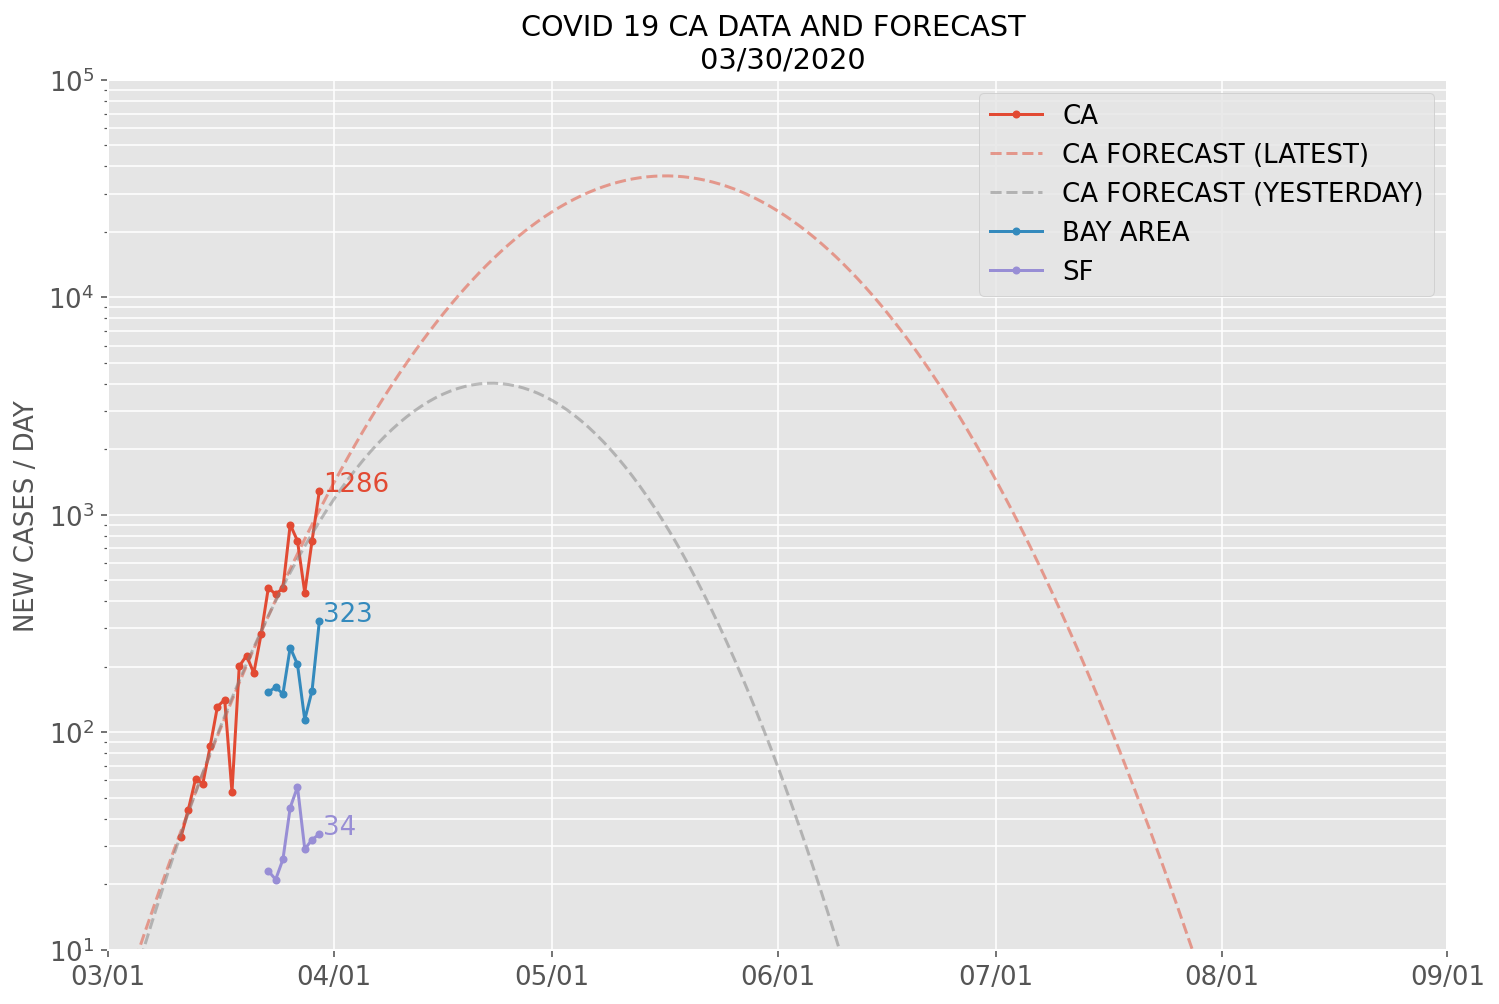

In [58]:
# CALIFORNIA FORECAST: CONFIRMED NEW

# forecast: latest
data_ca_copy = data_ca.dropna()
ds_data = data_ca_copy.ds
x_data = [(ds - dt.datetime(2020,1,1)).days for ds in data_ca_copy.ds]
y_data = np.log(data_ca_copy.Confirmed_new)

f = lambda x, a, b, c:a*(x-b)**2 + c
p = curve_fit(f, x_data, y_data)[0]
print(p)

x_forecast = np.arange(0,365)
ds_forecast = [dt.datetime(2020,1,1) + dt.timedelta(int(k)) for k in x_forecast]
y_forecast = [f(x, p[0], p[1], p[2]) for x in x_forecast]

# forecast: previous day
data_ca_copy = data_ca.dropna()
ds_data = data_ca_copy.ds
x_data_prev = [(ds - dt.datetime(2020,1,1)).days for ds in data_ca_copy.ds][:-1]
y_data_prev = np.log(data_ca_copy.Confirmed_new)[:-1]

f = lambda x, a, b, c:a*(x-b)**2 + c
p = curve_fit(f, x_data_prev, y_data_prev)[0]
print(p)

x_forecast = np.arange(0,365)
ds_forecast = [dt.datetime(2020,1,1) + dt.timedelta(int(k)) for k in x_forecast]
y_forecast_prev = [f(x, p[0], p[1], p[2]) for x in x_forecast]

# plots
ax1 = pl.plot(data_ca.ds, data_ca.Confirmed_new, marker='.', label='CA')
pl.plot(ds_forecast, np.exp(y_forecast), c=ax1[0].get_color(), ls='--', alpha=0.5, label='CA FORECAST (LATEST)')
pl.plot(ds_forecast, np.exp(y_forecast_prev), c='gray', ls='--', alpha=0.5, label='CA FORECAST (YESTERDAY)')
pl.text(data_ca.ds.iloc[-1]+dt.timedelta(0.5), data_ca.Confirmed_new.iloc[-1], s=int(data_ca.Confirmed_new.iloc[-1]), c=ax1[0].get_color(), fontsize=13)

ax2 = pl.plot(data_bay.ds, data_bay.Confirmed_new, marker='.',  label='BAY AREA')
pl.text(data_bay.ds.iloc[-1]+dt.timedelta(0.5), data_bay.Confirmed_new.iloc[-1], s=int(data_bay.Confirmed_new.iloc[-1]), c=ax2[0].get_color(), fontsize=13)

ax3 = pl.plot(data_sf.ds, data_sf.Confirmed_new, marker='.',  label='SF')
pl.text(data_sf.ds.iloc[-1]+dt.timedelta(0.5), data_sf.Confirmed_new.iloc[-1], s=int(data_sf.Confirmed_new.iloc[-1]), c=ax3[0].get_color(), fontsize=13)

# formatting
fmt = mdates.DateFormatter("%m/%d")
ax = pl.gca()
ax.xaxis.set_major_formatter(fmt)

pl.title('COVID 19 CA DATA AND FORECAST \n {0}'.format(data_ca.ds.iloc[-1].strftime('%m/%d/%Y')))
pl.xlim(dt.datetime(2020,3,1), dt.datetime(2020,9,1))
pl.ylim(10, 1e5)
pl.yscale('log')
pl.ylabel('NEW CASES / DAY', fontsize=13)
pl.legend(fontsize=13)
pl.xticks(fontsize=13)
pl.yticks(fontsize=13)
pl.grid(True,which="both",ls="-")



[ 1.18186110e-03  4.12790484e-01 -6.04271465e+00]


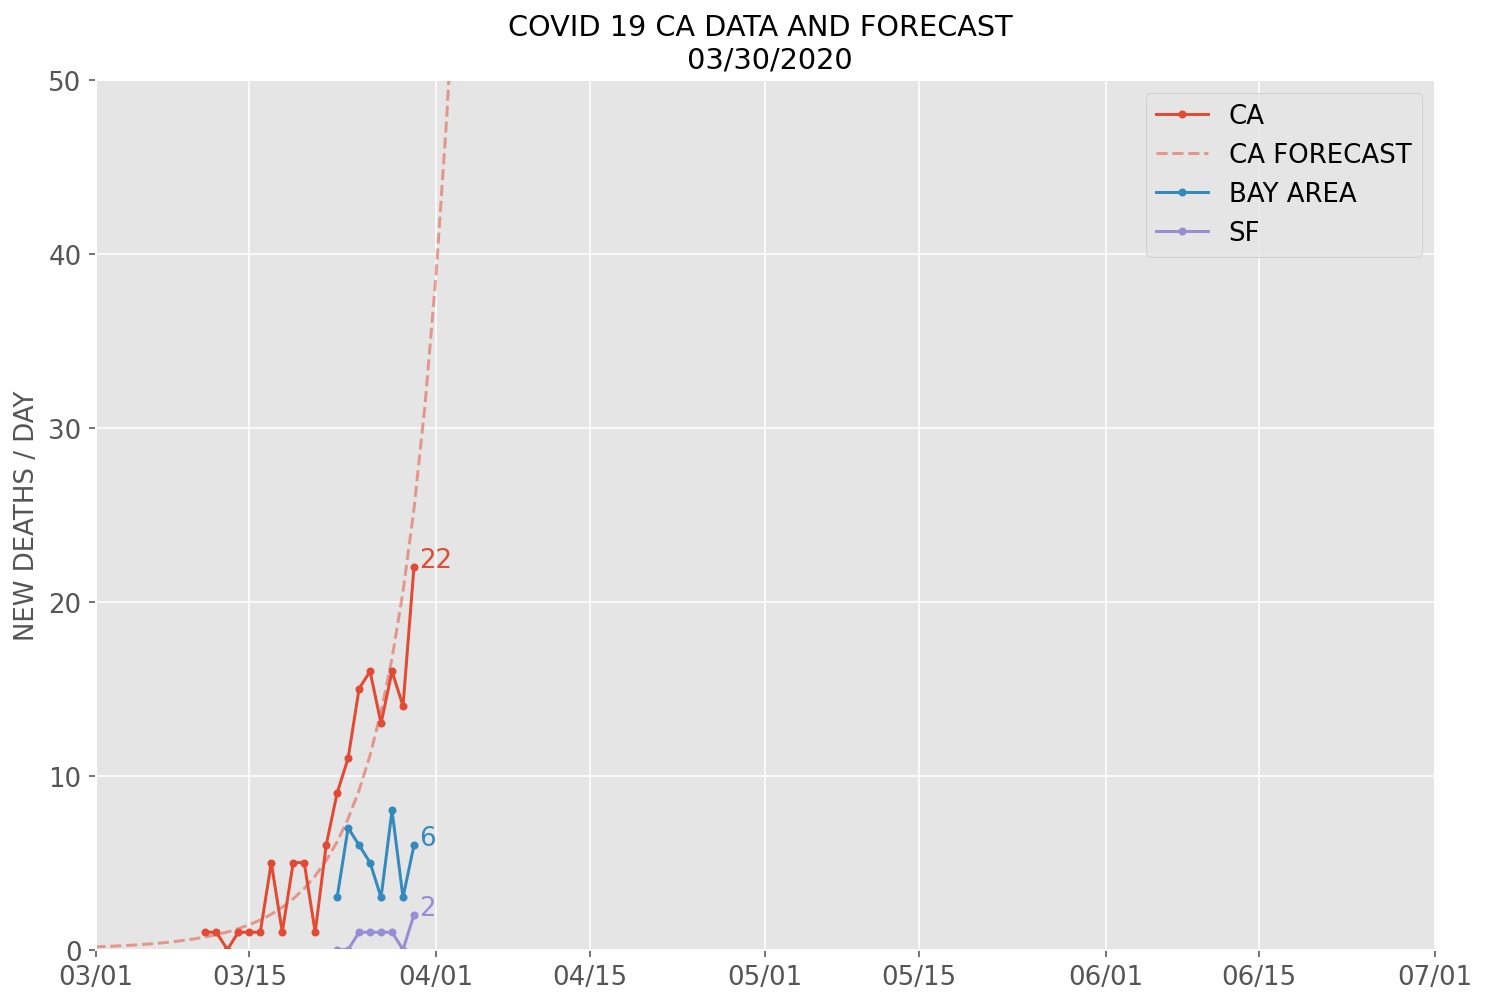

In [62]:
# CALIFORNIA FORECAST: DEATHS NEW

# forecast
data_ca_copy = data_ca.replace(to_replace={'Deaths_new':0.}, value=np.nan)
data_ca_copy = data_ca_copy.dropna() # remove nan and zeros
ds_data = data_ca_copy.ds
x_data = [(ds - dt.datetime(2020,1,1)).days for ds in data_ca_copy.ds]
y_data = np.log(data_ca_copy.Deaths_new)

f = lambda x, a, b, c:a*(x-b)**2 + c
p = curve_fit(f, x_data, y_data)[0]
print(p)

x_forecast = np.arange(0,365)
ds_forecast = [dt.datetime(2020,1,1) + dt.timedelta(int(k)) for k in x_forecast]
y_forecast = [f(x, p[0], p[1], p[2]) for x in x_forecast]

# plots
# death_over_confirmed = np.mean(data_ca.Deaths_new*1./data_ca.Confirmed_new)
ax1 = pl.plot(data_ca.ds, data_ca.Deaths_new, marker='.', label='CA')
pl.plot(ds_forecast, np.exp(y_forecast), c=ax1[0].get_color(), ls='--', alpha=0.5, label='CA FORECAST')
pl.text(data_ca.ds.iloc[-1]+dt.timedelta(0.5), data_ca.Deaths_new.iloc[-1], s=int(data_ca.Deaths_new.iloc[-1]), c=ax1[0].get_color(), fontsize=13)

ax2 = pl.plot(data_bay.ds, data_bay.Deaths_new, marker='.',  label='BAY AREA')
pl.text(data_bay.ds.iloc[-1]+dt.timedelta(0.5), data_bay.Deaths_new.iloc[-1], s=int(data_bay.Deaths_new.iloc[-1]), c=ax2[0].get_color(), fontsize=13)

ax3 = pl.plot(data_sf.ds, data_sf.Deaths_new, marker='.',  label='SF')
pl.text(data_sf.ds.iloc[-1]+dt.timedelta(0.5), data_sf.Deaths_new.iloc[-1], s=int(data_sf.Deaths_new.iloc[-1]), c=ax3[0].get_color(), fontsize=13)

# formatting
fmt = mdates.DateFormatter("%m/%d")
ax = pl.gca()
ax.xaxis.set_major_formatter(fmt)

pl.title('COVID 19 CA DATA AND FORECAST \n {0}'.format(data_ca.ds.iloc[-1].strftime('%m/%d/%Y')))
pl.xlim(dt.datetime(2020,3,1), dt.datetime(2020,7,1))
pl.ylim(0, 50)
# pl.yscale('symlog')
pl.ylabel('NEW DEATHS / DAY', fontsize=13)
pl.legend(fontsize=13)
pl.xticks(fontsize=13)
pl.yticks(fontsize=13)
pl.grid(True,which="both",ls="-")
